In [1]:
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import numpy as np

%matplotlib inline

## Import & split data into events

In [2]:
with open("master1.txt","r") as f:
    master1 = f.readlines()
list1 = [line.strip('\n') for line in master1]

list2 = []
for x in range(len(list1)):
    line = list1[x].split('  ')
    line = [string for string in line if ((string != '') & (string != ' '))]
    for index in range(len(line)):
        if line[index][0] == ' ':
            line[index] = line[index][1:]
        if index in (2,3,7):
            line[index] = float(line[index])
            if ((line[index] > 0) & (str(line[index])[::1].find('.') == 1)):
                line[index] = float(line[index])*10
            elif ((line[index] < 0) & (str(line[index])[::1].find('.') == 2)):
                line[index] = float(line[index])*10                    
        elif index in (0,4,5,6):
            line[index] = int(line[index])
    if len(line) == 8:
        line.append('UNKNOWN')
    list2.append(line)

for i in range(1,len(list2)):
    if (list2[i][7] < list2[i-1][7]) & (list2[i][0] == list2[i-1][0]):
        list2[i][7] = list2[i-1][7] + 0.25

In [3]:
# IDs of events that become hurricanes
hurr_ID = list(set([list2[i][0] for i in range(len(list2)) if (list2[i][8][0] == 'H')]))

# Collect hurricanes into separate lists
hurr_data = [[list2[j] for j in range(len(list2)) if list2[j][0] == i] for i in hurr_ID]

## 2. Frequency of events

In [4]:
hurr_years = [hurr_data[i][0][6] for i in range(len(hurr_data))] # year of each hurricane

# Decade of each hurricane
decades = np.arange(hurr_years[0],hurr_years[-1]+1,10)
hurr_years_dec = [int(np.floor(i/10)*10) for i in hurr_years]

# Count events in each decade
decade_counts = [hurr_years_dec.count(i) for i in decades]
decade_counts_lower = [i - np.sqrt(i) for i in decade_counts]
decade_counts_upper = [i + np.sqrt(i) for i in decade_counts]

In [5]:
def least_sq_line(x1,y1):
    N = len(x1)
    x2 = [x**2 for x in x1]
    y2 = [y**2 for y in y1]
    xy = [x1[i] * y1[i] for i in range(N)]
    
    delta = (N * np.sum(x2)) - (np.sum(x1))**2
    A = (1/delta) * ( np.multiply(np.sum(x2), np.sum(y1)) - np.multiply(np.sum(x1), np.sum(xy)) )
    B = (1/delta) * ( (N * np.sum(xy)) - np.multiply(np.sum(x1), np.sum(y1)) )
    
    y_err = np.sqrt(np.sum([(y1[i] - A - (B*x1[i]))**2 for i in range(N)]) / (N-2))
    
    return A, B, y_err

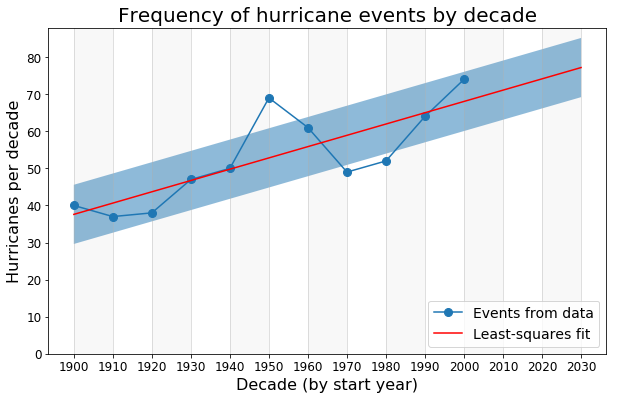

In [6]:
# Linear fit
A, B, y_err = least_sq_line(decades, decade_counts)

# Extend fit to 2030
x = np.append(decades, [2010, 2020, 2030])
y_lower = [x[i]*B + A - y_err for i in range(len(x))]
y_upper = [x[i]*B + A + y_err for i in range(len(x))]

plt.figure(figsize=(10,6))
plt.plot(decades, decade_counts, ".-", markersize=16, label="Events from data")
plt.plot(x, A + B*x, 'r-', label='Least-squares fit')
plt.fill_between(x, y_lower, y_upper, alpha=.5)
plt.xticks(x, size=12)
plt.yticks(np.arange(0, np.max(decade_counts)*1.1,10), size=12)
plt.title("Frequency of hurricane events by decade", size=20)
plt.xlabel("Decade (by start year)", size=16)
plt.ylabel("Hurricanes per decade", size=16)
for i in x[::2]:
    plt.axvspan(i, i+10, facecolor="grey", alpha=0.05)
ax = plt.axes()
ax.xaxis.grid(alpha=0.5)

plt.legend(loc="lower right", fontsize=14)
plt.show()

A least-squares linear fit as detailed in Taylor's "Intro to Error Analysis". The uncertainty bounds on the linear fit are computed as the standard deviation of the event rate from the values interpolated by the fit.

## 3. Florida impact

In [7]:
# Coordinates of Florida polygon
vertices = [(25.1, -79.3),
      (30.8, -81.5),
      (30.8, -87.6),
      (30.0, -87.6),
      (30.0, -83.8),
      (25.1, -81.7),
      (25.1, -79.3)]

codes = [mplPath.Path.MOVETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO]

# Create Path object for Florida
fl_path = mplPath.Path(vertices, codes)

In [8]:
# Gather impact data
impact = [] # subset of hurr_data containing points of impact
impact_dt = [] # hurricane durations
for j in range(len(hurr_data)):
    for i in range(len(hurr_data[j])):
        pos = (hurr_data[j][i][2], hurr_data[j][i][3])
        if (fl_path.contains_point(pos) == True) & (hurr_data[j][i][8][0] == "H"):
            impact.append(hurr_data[j][i])
            t_start = hurr_data[j][i][7]
            t_stop = hurr_data[j][i][7]
            for k in range(i+1,len(hurr_data[j])):
                pos_k = (hurr_data[j][k][2], hurr_data[j][k][3])
                if fl_path.contains_point(pos_k) == True:
                    t_stop = hurr_data[j][k][7]
                else:
                    break
            impact_dt.append(24*(t_stop - t_start))
            break
impact_ws = [impact[i][4] for i in range(len(impact))] # impact windspeed

# Impact factor = (impact wind speed) * (hurricane duration over Florida)
impact_factor = [impact_ws[i] * impact_dt[i] for i in range(len(impact_ws))]

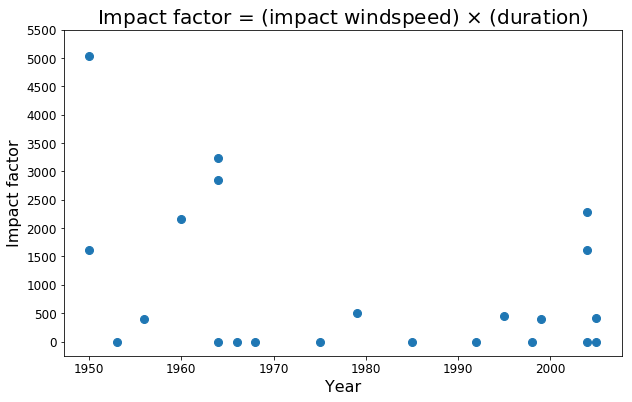

In [9]:
impact_year = [impact[i][6] for i in range(len(impact))]

x = [impact_year[i] for i in range(len(impact)) if (impact_year[i] >= 1950)]
y = [impact_factor[i] for i in range(len(impact)) if (impact_year[i] >= 1950)]
plt.figure(figsize=(10,6))
plt.plot(x, y, ".", markersize=16)
plt.xticks(np.arange(1950,2010,10), size=12)
plt.yticks(np.arange(0,np.max(impact_factor)*1.1,500), size=12)
plt.title("Impact factor = (impact windspeed) $\\times$ (duration)", size=20)
plt.xlabel("Year", size=16)
plt.ylabel("Impact factor", size=16)

plt.show()

It's very difficult to make inferences based on this limited data, since there are so few data points, and many of them are zero-valued data points (due to missing wind speed data). The three highest impact factors appear in the 1950s and 60s, and there are a couple other significant impact factors around that time period; there are also two noticeable storms appearing in the 2000s. From the mid 60s to early 2000s, things are fairly quite in this data set, so apart from the two major storms of the 2000s, the data suggests that things might be getting better for Florida.

## 4. Minimum central pressures

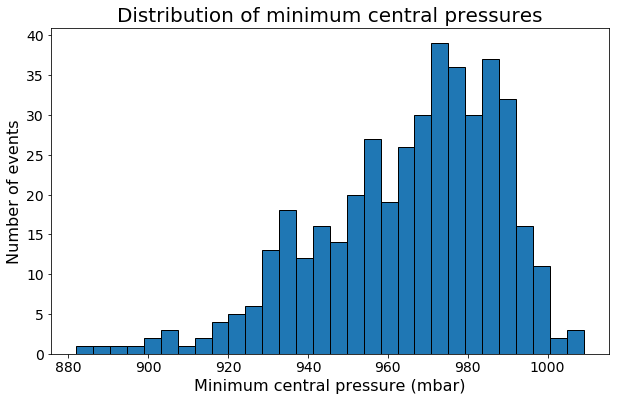

Average minimum central pressure = 965.151869159 mbar 
Standard deviation of minimum central pressure= 22.6637926329 mbar
Total number of events = 428
[892, 888, 897, 882]


In [10]:
wp_min = []
for i in range(len(hurr_data)):
    wp_list = [hurr_data[i][j][5] for j in range(len(hurr_data[i]))]
    wp_list = [wp_list[k] for k in range(len(wp_list)) if wp_list[k] > 0]
    if len(wp_list) > 0:
        wp_min.append(min(wp_list))


plt.figure(figsize=(10,6))
hist, bins, patches = plt.hist(wp_min, 30, edgecolor="k")
plt.title("Distribution of minimum central pressures", size=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Minimum central pressure (mbar)", size=16)
plt.ylabel("Number of events", size=16)

plt.show()


wp_min_avg = np.mean([wp_min])
wp_min_std = np.std([wp_min])
print("Average minimum central pressure =", wp_min_avg, "mbar",
     "\nStandard deviation of minimum central pressure=", wp_min_std, "mbar")
print('Total number of events =', len(wp_min))
print([wp_min[i] for i in range(len(wp_min)) if (wp_min[i] < (wp_min_avg - 3*wp_min_std)) or (wp_min[i] > (wp_min_avg + 3*wp_min_std))])

The minimum central pressures of all the hurricanes has an average value of 965.2 mbar, with a standard deviation of 22.7 mbar. Out of 428 events, we would expect (for a normal distribution of events) 99.8% of the data (less than one data point) to lie within 3 standard deviations of the mean, i.e. between 897.1 and 1033.3 mbar. Rather, there are four data points below the lower bound, with pressures of 882, 88, 892, and 897 mbar, and no data points above the upper bound. This suggests that the data may not be normally distributed, i.e. the storms do not deviate equally in either direction. There is a higher chance of pressure dropping very low than rising very high, which is consistent with the fact that the central pressure of a hurricane drops as it develops.

## 5. Hurrican categories

In [11]:
cat = []
for i in range(len(hurr_data)):
    event_list = [hurr_data[i][j][8] for j in range(len(hurr_data[i]))]
    cat.append((hurr_data[i][0][6], np.max([int(event_list[k][-1]) for k in range(len(event_list)) if event_list[k][0] == "H"])))
cat_dec = [(int(np.floor(cat[i][0]/10)*10), cat[i][1]) for i in range(len(cat))]

decades = np.arange(hurr_years[0],hurr_years[-1]+1,10)

pie = []
j = 0
for i in range(len(decades)):
    x = []
    while (cat_dec[j][0] == decades[i]):
        x.append(cat_dec[j][1])
        if j < len(cat_dec)-1: j += 1
        else: break
    pie.append([x.count(k) for k in range(1,6)])
pie = list(zip(decades, pie))

In [12]:
labels = ["Cat-1", "Cat-2", "Cat-3", "Cat-4", "Cat-5"]
def labeler(i):
    return [labels[j] if pie[i][1][j] != 0 else '' for j in range(len(labels))]
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

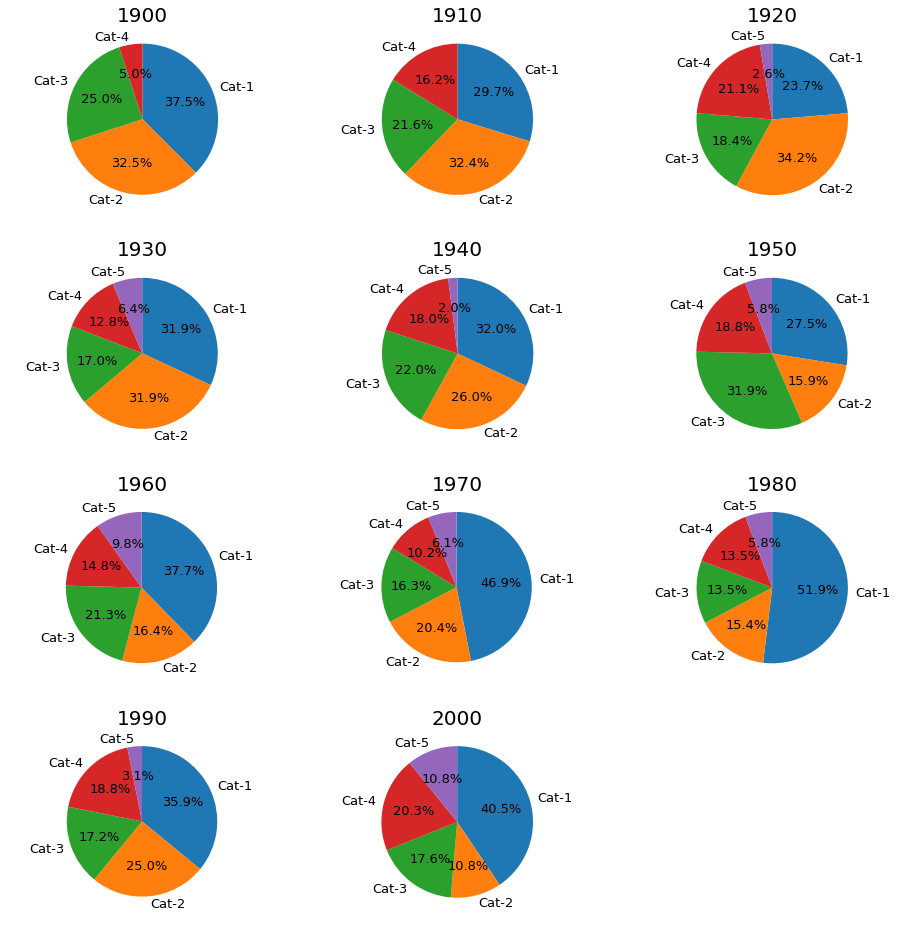

In [13]:
f, axarray = plt.subplots(4,3, figsize=(16,16))
axs = axarray.ravel()
for i in range(11):
    patches, texts, autotexts = axs[i].pie(pie[i][1], labels=labeler(i), autopct=my_autopct, counterclock=False, startangle=90)
    axs[i].axis("equal")
    axs[i].set_title(str(decades[i]), fontsize=20, y = 1.05)
    for j in range(len(texts)):
        texts[j].set_fontsize(13)
        autotexts[j].set_fontsize(13)
axs[-1].axis('off')
f.subplots_adjust(hspace=.4)
plt.show()

## 6. Hurrican threat level

In [14]:
standard = 1000
threat = 970 #mbar

t_spin = []
t_spin_year = []
for i in range(len(hurr_data)):
    wp_list = [hurr_data[i][j][5] for j in range(len(hurr_data[i]))]
    wp_list_time = [hurr_data[i][j][7] for j in range(len(hurr_data[i]))]
    wp_list = [wp_list[k] for k in range(len(wp_list)) if wp_list[k] > 0]
    wp_list_time = [wp_list_time[k] for k in range(len(wp_list)) if wp_list[k] > 0]
    if (len(wp_list) > 0):
        if (max(wp_list) >= 1000) & (min(wp_list) <= 970):
            wp_initial = min([wp_list[m] for m in range(len(wp_list)) if (wp_list[m] >= 1000)])
            wp_final = max([wp_list[m] for m in range(len(wp_list)) if (wp_list[m] <= 970)])
            wp_initial_index = wp_list.index(wp_initial)
            wp_final_index = wp_list.index(wp_final)
            if wp_final_index > wp_initial_index:
                t_spin.append(wp_list_time[wp_final_index] - wp_list_time[wp_initial_index])
                t_spin_year.append(hurr_data[i][0][6])

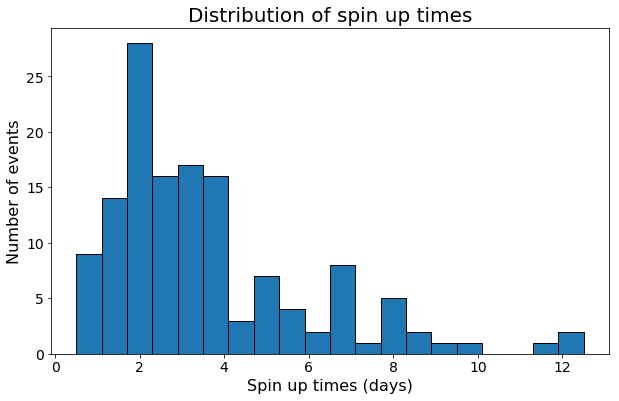

In [15]:
plt.figure(figsize=(10,6))
hist, bins, patches = plt.hist(t_spin, 20, edgecolor="k") # histogram, 30 bins
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Distribution of spin up times", size=20)
plt.xlabel("Spin up times (days)", size=16)
plt.ylabel("Number of events", size=16)

plt.show()

Average spin up times:
For 1990-2010: 3.96710526316 
For 1950-1970 2.39166666667


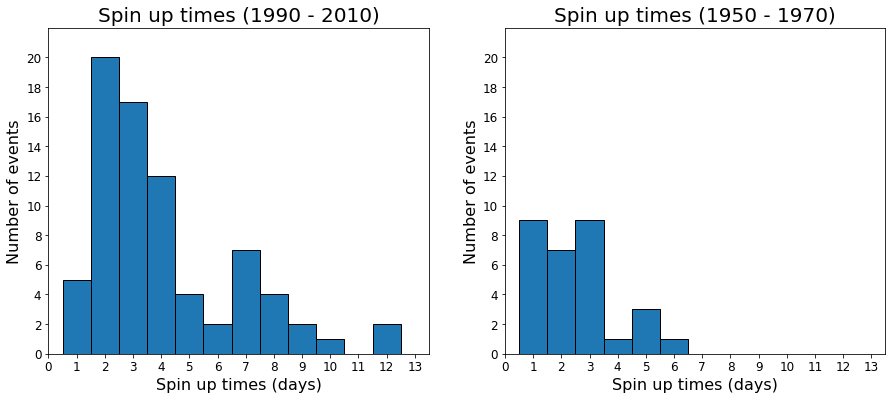

In [16]:
x1 = [t_spin[i] for i in range(len(t_spin)) if (t_spin_year[i] >= 1990) & (t_spin_year[i] <= 2010)]
x2 = [t_spin[i] for i in range(len(t_spin)) if (t_spin_year[i] >= 1950) & (t_spin_year[i] <= 1970)]
print('Average spin up times:\nFor 1990-2010:', np.mean(x1), '\nFor 1950-1970', np.mean(x2))

plt.figure(figsize=(15,6))

xmax = max([max(x1), max(x2)])+1
ymax = 22

bin_edges = np.arange(0.5, xmax, 1)

plt.subplot(1,2,1)
hist1, bins1, patches1 = plt.hist(x1, bins=bin_edges, edgecolor="k")
plt.xlim([0, xmax])
plt.ylim([0, ymax])
plt.xticks(np.arange(0, xmax), size=12)
plt.yticks(np.arange(0, ymax, 2), size=12)
plt.title("Spin up times (1990 - 2010)", size=20)
plt.xlabel("Spin up times (days)", size=16)
plt.ylabel("Number of events", size=16)

plt.subplot(1,2,2)
hist2, bins2, patches2 = plt.hist(x2, bins=bin_edges, edgecolor="k")
plt.xlim([0, xmax])
plt.ylim([0, ymax])
plt.xticks(np.arange(0, xmax), size=12)
plt.yticks(np.arange(0, ymax, 2), size=12)
plt.title("Spin up times (1950 - 1970)", size=20)
plt.xlabel("Spin up times (days)", size=16)
plt.ylabel("Number of events", size=16)

plt.show()

The distribution of spin up times hasn't changed much over the decade, although the number of hurricanes in 1990-2010 is considerably higher than that in 1950-1970, and the average spin-up time has increased from about 2.4 to 4.0 days.

## 7. Category-3 lifetimes

In [17]:
cat3_time = []
cat3_year = []
for i in range(len(hurr_data)):
    event_list = [hurr_data[i][j][8] for j in range(len(hurr_data[i]))]
    for j in range(len(event_list)):
        if (event_list[j][0] == "H"):
            if (int(event_list[j][-1]) >= 3):
                t_start = hurr_data[i][j][7]
                t_stop = t_start
                for k in range(j, len(event_list)):
                    if (int(event_list[j][-1]) >= 3):
                        t_stop = hurr_data[i][k][7]
                    else:
                        break
                cat3_time.append(t_stop-t_start)
                cat3_year.append(hurr_data[i][j][6])
                break

cat3_dec = [(int(np.floor(cat3_year[i]/10)*10), cat3_time[i]) for i in range(len(cat3_time))]
decades = np.arange(hurr_years[0],hurr_years[-1]+1,10)
cat3_dec_avg = [np.mean([cat3_dec[j][1] for j in range(len(cat3_dec)) if cat3_dec[j][0] == i]) for i in decades]

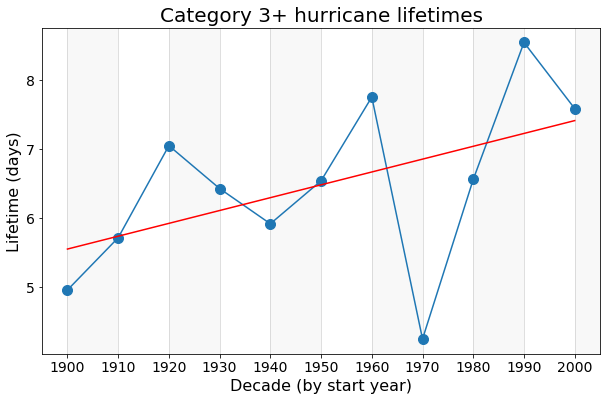

In [18]:
# Linear fit to data
coeffs = np.polyfit(decades, cat3_dec_avg, 1)

plt.figure(figsize=(10,6))
plt.plot(decades, cat3_dec_avg, '.-', markersize=20)
plt.plot(decades, decades*coeffs[0] + coeffs[1], 'r-')
plt.xlim(1895, 2005)
plt.xticks(decades, size=14)
plt.yticks(size=14)
plt.title('Category 3+ hurricane lifetimes', fontsize=20)
plt.xlabel('Decade (by start year)', fontsize=16)
plt.ylabel('Lifetime (days)', fontsize=16)
for i in decades[::2]:
    plt.axvspan(i, i+10, facecolor="grey", alpha=0.05)
ax = plt.axes()
ax.xaxis.grid(alpha=0.5)

plt.show()

The amount of time storms are spending at a Category 3 or higher level has been increasing overall.

## 8. Intensification zone

In [19]:
# Coordinates of intensification zone
vertices = [(15., -50.), (15., -65.), (22., -65.), (22., -50.), (15., -50.)]

codes = [mplPath.Path.MOVETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO,
        mplPath.Path.LINETO]

# Create Path object for intensification zone
iz_path = mplPath.Path(vertices, codes)

# Example of checking if a coordinate is in the region
# print(iz_path.contains_point((20., -55.)))

iz_data = []
for i in range(len(hurr_data)):
    for j in range(len(hurr_data[i])):
        pos = (hurr_data[i][j][2], hurr_data[i][j][3])
        if iz_path.contains_point(pos):
            iz_data.append(hurr_data[i])
            break
iz_data_dec = [int(np.floor(i[0][6]/10)*10) for i in iz_data]
decades = np.arange(hurr_years[0],hurr_years[-1]+1,10)
iz_counts = [iz_data_dec.count(i) for i in decades]
iz_counts_avg = np.mean(iz_counts)
iz_counts_std = np.std(iz_counts)

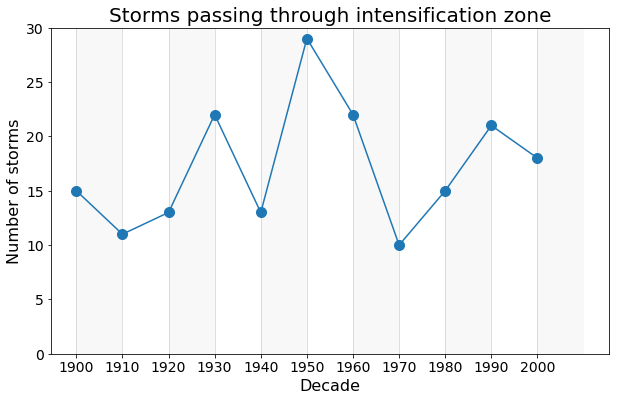

In [20]:
plt.figure(figsize=(10,6))
plt.plot(decades, iz_counts, '.-', markersize=20)
plt.xticks(decades, size=14)
plt.yticks(np.arange(0, 31, 5), size=14)
plt.title('Storms passing through intensification zone', size=20)
plt.xlabel('Decade', size=16)
plt.ylabel('Number of storms', size=16)
for i in decades[::2]:
    plt.axvspan(i, i+10, facecolor="grey", alpha=0.05)
ax = plt.axes()
ax.xaxis.grid(alpha=0.5)

plt.show()

In [21]:
iz_cat = []
for i in iz_data:
    event_list = [i[j][8] for j in range(len(i))]
    year = i[0][6]
    cat = np.max([int(event_list[k][-1]) for k in range(len(event_list)) if event_list[k][0] == "H"])
    lat = next(i[j][2] for j in range(len(i)) if i[j][8][-1] == str(cat))
    
    iz_cat.append((year, lat, cat))

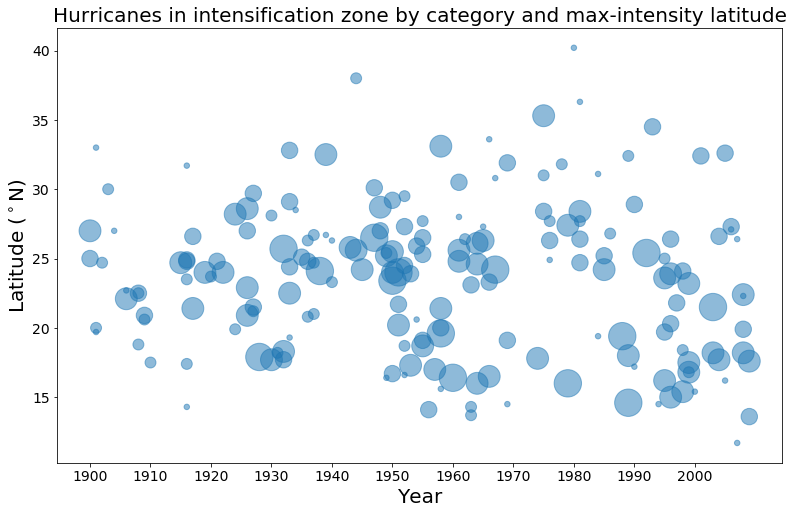

In [22]:
x, y, r = [list(i) for i in list(zip(*iz_cat))]

plt.figure(figsize=(13,8))
plt.scatter(x, y, s=[(i**2)*30 for i in r], alpha=0.5)
plt.xticks(decades, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Hurricanes in intensification zone by category and max-intensity latitude', size=20)
plt.xlabel('Year', size=20)
plt.ylabel('Latitude ($^\circ$N)', size=20)

plt.show()

### Poisson statistics

In [23]:
iz_cat_dec = [[iz_cat[j][2] for j in range(len(iz_cat)) if int(np.floor(iz_cat[j][0]/10)*10) == i] for i in decades]
iz_cat_count = [[i.count(j) for j in range(1,6)] for i in iz_cat_dec]
iz_cat_avg = [np.mean([[iz_cat_count[i][j] for i in range(len(iz_cat_count))] for j in range(5)][k]) for k in range(5)]

print('category: |1, 2, 3, 4, 5|')
for i in range(len(decades)):
    print(decades[i], ':   ', iz_cat_count[i])
for i in range(5):
    print('Avg number of cat-{} hurricanes per decade = {:.1f} +/- {:.1f}'.format(i+1, iz_cat_avg[i], np.sqrt(iz_cat_avg[i])))

category: |1, 2, 3, 4, 5|
1900 :    [4, 6, 3, 2, 0]
1910 :    [2, 3, 3, 3, 0]
1920 :    [0, 3, 4, 5, 1]
1930 :    [3, 7, 6, 4, 2]
1940 :    [2, 3, 2, 5, 1]
1950 :    [3, 3, 12, 8, 3]
1960 :    [5, 3, 5, 7, 2]
1970 :    [1, 3, 2, 3, 1]
1980 :    [4, 3, 3, 3, 2]
1990 :    [2, 3, 7, 8, 1]
2000 :    [6, 0, 6, 5, 1]
Avg number of cat-1 hurricanes per decade = 2.9 +/- 1.7
Avg number of cat-2 hurricanes per decade = 3.4 +/- 1.8
Avg number of cat-3 hurricanes per decade = 4.8 +/- 2.2
Avg number of cat-4 hurricanes per decade = 4.8 +/- 2.2
Avg number of cat-5 hurricanes per decade = 1.3 +/- 1.1


For most decades, the number of events by category sometimes falls beyond a standard deviation from the overall average rate per decade. However, the 1950s is the only decade where one of the categories was beyond two standard deviations: there were 12 category-3 hurricans in 1950s.